In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import re
from tqdm import tqdm,trange
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
os.chdir('C:\\Users\\ASUS\\PycharmProjects\\RahnemaProject')

In [3]:
df = pd.read_csv('feature_extracted_mid.csv')
df = df.drop('Unnamed: 0',axis=1)

In [ ]:
df.head()

In [5]:
pd.to_datetime(df['date_time'],unit='ms')

0         2021-05-12 00:36:00
1         2021-05-12 00:36:00
2         2021-05-12 00:36:00
3         2021-05-12 00:36:00
4         2021-05-12 00:36:00
                  ...        
1260030   2021-05-12 10:38:59
1260031   2021-05-12 10:38:59
1260032   2021-05-12 10:38:59
1260033   2021-05-12 10:38:59
1260034   2021-05-12 10:39:00
Name: date_time, Length: 1260035, dtype: datetime64[ns]

In [6]:
df = df.set_index(pd.to_datetime(df['date_time'],unit='ms'))
df = df.drop('date_time',axis=1)

In [7]:
#first_session = df.between_time('00:36:00','01:00:00').groupby(['client_ip',
 #   'user_agent']).mean()[['response_time','response_length','time_interval']]\
  #  .sort_values('response_time',ascending=False)

#for index,row in df[0:5].iterrows():
 #    i = pd.to_datetime(index).astype(int)/10**6

In [8]:
time_index = df.resample('2min')
#for name,group in time_index:
 #   print(name)

In [9]:
resampled_df = pd.DataFrame(time_index,columns=['date_time','columns'])
resampled_df = resampled_df.reset_index()
resampled_df = resampled_df.set_index('date_time')

In [10]:
resampled_df = resampled_df.drop('columns',axis=1)
resampled_df.head()

,index
date_time,
2021-05-12 00:36:00,0
2021-05-12 00:38:00,1
2021-05-12 00:40:00,2
2021-05-12 00:42:00,3
2021-05-12 00:44:00,4


In [11]:
resampled_df['index'].nunique()

302

In [12]:
resampled_df = pd.DataFrame(resampled_df.resample('s').ffill())

In [14]:
%time
#df = df.drop('session_number',axis=1)
#new_df = pd.concat([df,resampled_df],axis=1)
#new_df = df.reset_index()

new_df = pd.merge(df.reset_index(),resampled_df.reset_index(),left_on='date_time',right_on='date_time')

Wall time: 0 ns


In [15]:
new_df.loc[new_df['geolocation'].isnull()==True,'geolocation'] = 'NaN'
new_df.loc[new_df['last_page'].isnull()==True,'last_page'] = 'NaN'

In [16]:
new_df = new_df.reset_index()
new_df['date_time'] = pd.to_datetime(new_df['date_time'],'ms')
new_df['time'] = new_df['date_time'].apply(lambda x:x.value)
new_df = new_df.set_index('date_time')

#new_df['date_time'] = pd.to_datetime(new_df['date_time']).astype(int)/10**6

new_df = new_df.drop('level_0',axis=1)

In [16]:
new_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258053 entries, 2021-05-12 00:36:00 to 2021-05-12 10:38:00
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   client_ip        1258053 non-null  object 
 1   response_length  1258053 non-null  int64  
 2   user_agent       1258053 non-null  object 
 3   response_time    1258053 non-null  float64
 4   path             1258053 non-null  object 
 5   geolocation      1258053 non-null  object 
 6   last_refer       1258053 non-null  float64
 7   coded_path       1258053 non-null  object 
 8   last_page        1258053 non-null  object 
 9   time_interval    1258053 non-null  float64
 10  is_pc            1258053 non-null  int64  
 11  Get              1258053 non-null  int64  
 12  Post             1258053 non-null  int64  
 13  200              1258053 non-null  int64  
 14  304              1258053 non-null  int64  
 15  400              1258053 non-null

Define Features
---


In [17]:
session_1 = new_df.groupby(['index','client_ip','user_agent']).median()[['response_length','depth']]
session_2 = new_df.groupby(['index','client_ip','user_agent']).mean()[['response_time','time_interval']]

session_2.columns = ['avg_response_time','avg_time_interval_Std']

In [18]:
session_3 = new_df.groupby(['index','client_ip','user_agent']).std()[['response_time','time_interval']]
session_3.columns = ['response_time_std','time_interval_Std']

In [19]:
session_4 = new_df.groupby(['index','client_ip','user_agent']).sum()[['is_pc','Get','Post','image','400']]

In [20]:
session_5 = new_df.groupby(['index','client_ip','user_agent']).apply(lambda x:x.html.sum()/x.css_font_js.sum() if x.css_font_js.sum() !=0 else 0)
session_5 = pd.DataFrame(session_5,columns=['html/css'])

In [21]:
session_6 = new_df.groupby(['index','client_ip','user_agent']).apply(
    lambda x:(x['400'].sum()+x['404'].sum()+x['499'].sum())/x['200'].sum() if x['200'].sum()!=0 else 0)

session_6 = pd.DataFrame(session_6,columns=['4xx/200'])

In [22]:
session_7 = new_df.groupby(['index','client_ip','user_agent']).max()[['geolocation']]

In [23]:
session_8 = new_df.groupby(['index','client_ip','user_agent']).apply(
    lambda x:x.time.iloc[-1] - x.time.iloc[0])

session_8 = pd.DataFrame(session_8,columns=['lf_time_interval'])

In [24]:
session_9 = new_df.groupby(['index','client_ip','user_agent']).max()[['depth']]
session_9.columns = ['max_depth']
session_10 = new_df.groupby(['index','client_ip','user_agent']).std()[['depth']]
session_10.columns = ['std_depth']

In [138]:
# new_df['last_page'] = new_df.groupby(['client_ip','user_agent']).shift(1)['path']
# new_df.loc[new_df['last_page'].isnull()==True,'last_page']='NaN'
#
# new_df['return_count'] = new_df.apply(
#     lambda x:1  if
#         (len(x['last_page'].split('/'))>=2)
#         and
#         (x['path'].split('/')[-2] == x['last_page'].split('/')[-2])
#         else 0 , axis=1)
#
# new_df = new_df.drop('return_count',axis=1)

In [ ]:
session_11 = new_df.groupby(['index','client_ip','user_agent']).apply(
    lambda x: x.coded_path.split('-')[-1]
)

In [25]:
session_12 = new_df.groupby(['index','client_ip','user_agent']).apply(lambda x:x.is_pc.count())
#session_12 = new_df.groupby(['index','client_ip','user_agent']).count()['is_pc']
session_12 = pd.DataFrame(session_12, columns = ['number_of_requests'])

In [26]:
session_12['number_of_requests'].nunique()

240

In [17]:
session_13 = new_df.groupby(['index','user_agent']).apply(lambda x:x.client_ip.nunique() )

In [18]:
session_13 = pd.DataFrame(session_13, columns = ['times_ip_changed'])

In [30]:
#session_13['ip_changed'] = session_13['times_ip_changed'].apply(lambda x:1 if x>2 else 0)

In [119]:
#new_df = new_df.reset_index()
#new_df['time'] = new_df['date_time']
#new_df['date_time'] = pd.to_datetime(new_df['date_time'])
#new_df = new_df.set_index('date_time')
new_df.between_time('00:36','00:39').loc[(new_df.between_time('00:36','00:39')['client_ip']=='109.165.215.198')&(new_df.between_time('00:36','00:39')['user_agent']=='FreshpingBot/1.0 (+https://freshping.io/)')][['time']]

,time
date_time,
2021-05-12 00:36:43,1620779803000000000
2021-05-12 00:37:17,1620779837000000000
2021-05-12 00:38:56,1620779936000000000


In [92]:
new_df.groupby(['index','client_ip'])

Define Dataframe Based on Sessions
---

In [32]:
session_df = pd.concat([session_1,session_2,session_3,session_4,session_5,session_6,
                        session_7,session_8,session_9,session_10,session_12],axis=1)


In [20]:
session_df = pd.read_csv('session_defined_2min.csv')
session_df = session_df.set_index(['index','user_agent','client_ip'])

In [21]:
session_df = pd.merge(session_df.reset_index(),session_13.reset_index(),on=['index','user_agent'])
session_df = session_df.set_index(['index','client_ip','user_agent'])

In [20]:
#session_df = session_df.drop('ip_changed',axis=1)

In [31]:
session_df[session_df['times_ip_changed']==4].head()

med_response_length  \
index client_ip      user_agent                                                                
0     102.86.34.193  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...                  0.0   
      113.97.231.42  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...              28400.0   
      35.19.227.189  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...              29645.5   
      67.45.195.216  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...                  0.0   
      153.126.15.177 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...                183.0   

                                                                         med_depth  \
index client_ip      user_agent                                                      
0     102.86.34.193  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...        1.0   
      113.97.231.42  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...        1.0   
      35.19.227.189  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...        1.0   
      67.45.195.216  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...        1.0   
      153.126.15.177 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...        3.5   

                                                                         avg_response_time  \
index client_ip      user_agent                                                              
0     102.86.34.193  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...           4.571429   
      113.97.231.42  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...           7.200000   
      35.19.227.189  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...           8.250000   
      67.45.195.216  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...          12.000000   
      153.126.15.177 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...       86923.500000   

                                                                         avg_time_interval  \
index client_ip      user_agent                                                              
0     102.86.34.193  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       1.157700e+11   
      113.97.231.42  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       1.080520e+11   
      35.19.227.189  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       1.012987e+11   
      67.45.195.216  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       1.080520e+11   
      153.126.15.177 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...       8.103899e+11   

                                                                         std_response_time  \
index client_ip      user_agent                                                              
0     102.86.34.193  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...           2.138090   
      113.97.231.42  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...           9.096310   
      35.19.227.189  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...           5.927338   
      67.45.195.216  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...          31.386985   
      153.126.15.177 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...      122917.078880   

                                                                         std_time_interval  \
index client_ip      user_agent                                                              
0     102.86.34.193  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       4.331716e+11   
      113.97.231.42  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       4.184836e+11   
      35.19.227.189  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       4.051949e+11   
      67.45.195.216  Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like ...       4.184836e+11   
      153.126.15.177 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...       1.146064e+12   

                                                                         is_pc  \
index client_ip      user_agent                                                

In [27]:
session_df = session_df.drop('times_ip_changed_y',axis=1)

In [35]:
session_df.to_csv('session_defined_2min.csv')

In [26]:
x = pd.read_csv('session_defined.csv')
x = x.set_index(['index','client_ip','user_agent'])
#x = pd.concat([x,session_7],axis=1)

In [27]:
x.to_csv('session_defined.csv')

In [ ]:
session_df.iloc[10:20]

In [72]:
session_df['Get/number_of_requests'] = session_df.apply(lambda x:x['Get']/x['number_of_requests'],axis=1)

In [77]:
columns = ['med_depth','avg_time_interval','html/css', '4xx/200','Get/number_of_requests','image','times_ip_changed']

In [29]:
null_columns = ['std_response_time','std_time_interval','std_depth','location','is_bot']

In [ ]:
session_df.columns = ['med_response_length', 'med_depth', 'avg_response_time',
       'avg_time_interval', 'std_response_time', 'std_time_interval',
       'is_pc', 'Get', 'Post', 'image', '400', 'html/css', '4xx/200','location',
       'lf_time_interval', 'max_depth', 'std_depth','number_of_requests','times_ip_changed','is_bot']

In [23]:
from user_agents import parse

session_df = session_df.reset_index()
session_df = session_df.set_index(['index','client_ip'])
session_df['is_bot'] = session_df['user_agent'].apply(lambda x:parse(x).is_bot)
session_df['is_bot'] = session_df['is_bot'].apply(lambda x:1 if x==True else 0)


In [24]:
session_df = session_df.reset_index()
session_df = session_df.set_index(['index','client_ip','user_agent'])


In [52]:
session_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
med_response_length,130836.0,2.916701e+04,4.232397e+05,0.000000,236.500000,5.224000e+03,2.988700e+04,3.104202e+07
med_depth,130836.0,2.602158e+00,1.118233e+00,1.000000,1.000000,3.000000e+00,3.500000e+00,6.000000e+00
avg_response_time,130836.0,3.653502e+04,5.512795e+05,0.000000,11.000000,2.640000e+01,1.914525e+04,1.750470e+08
avg_time_interval,130836.0,2.608750e+11,5.211786e+11,38.461538,60000.000000,6.600000e+05,1.246756e+11,1.620816e+12
std_response_time,87813.0,2.099320e+04,8.013941e+04,0.000000,4.618802,1.037625e+01,2.259913e+03,8.648404e+06
std_time_interval,87813.0,2.487050e+11,3.595787e+11,0.000000,51961.524227,5.338656e+05,4.184906e+11,1.146090e+12
is_pc,130836.0,1.988635e+00,1.160247e+01,0.000000,0.000000,0.000000e+00,1.000000e+00,2.737000e+03
Get,130836.0,8.713382e+00,1.915906e+01,0.000000,1.000000,1.000000e+00,1.200000e+01,2.645000e+03
Post,130836.0,2.476688e-01,8.499742e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,4.200000e+01
image,130836.0,2.276720e+00,7.858488e+00,0.000000,0.000000,0.000000e+00,2.000000e+00,1.858000e+03


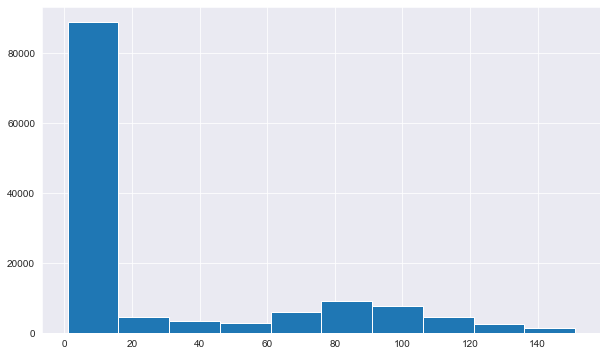

In [462]:
plt.figure(figsize=(10,6))
session_df['times_ip_changed'].hist()

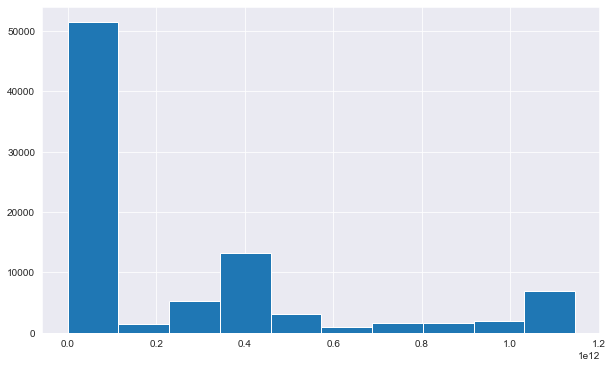

In [464]:
plt.figure(figsize=(10,6))
session_df['std_time_interval'].hist()

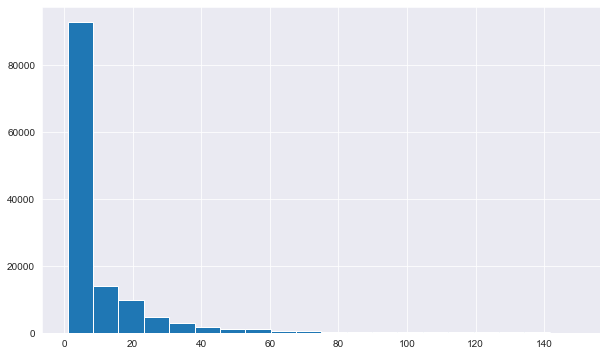

In [118]:
plt.figure(figsize=(10,6))
session_df[session_df['number_of_requests']<150]['number_of_requests'].hist(bins=20)

In [75]:
session_df[session_df['number_of_requests']>500]

,,,med_response_length,med_depth,avg_response_time,avg_time_interval,std_response_time,std_time_interval,is_pc,Get,Post,image,...,html/css,4xx/200,location,lf_time_interval,max_depth,std_depth,number_of_requests,times_ip_changed,is_bot,Get/number_of_requests
index,client_ip,user_agent,,,,,,,,,,,,,,,,,,,,,
283,35.26.221.84,"Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36",0.0,1.0,836.196361,1.228820e+09,4657.774804,4.462834e+10,1319.0,1276.0,0.0,892.0,...,0.447458,0.0,United States,43000000000,4,0.717090,1319,7,0,0.967400
284,35.26.221.84,"Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36",0.0,1.0,261.281695,4.859335e+01,1857.656868,7.169973e+02,2737.0,2645.0,0.0,1858.0,...,0.404153,0.0,United States,105000000000,4,0.681845,2737,6,0,0.966387


In [85]:
#new_df[(new_df['index']==283)&(new_df['client_ip']=='35.26.221.84')]


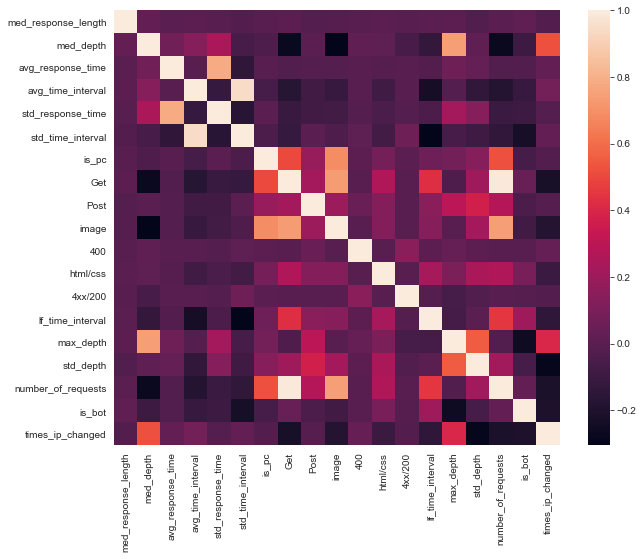

In [461]:
plt.figure(figsize=(10,8))
sns.heatmap(session_df.corr())

In [ ]:
new features:
    #get/num_requests
    avg_time_interval/lf_time_interval

Modeling
---

In [32]:
train = session_df[columns]

In [102]:
len(train) , len(session_df)


(130835, 130836)

In [45]:
np.where(DFpca[:,0]>48)

(array([120254, 120780], dtype=int64),)

In [78]:
train = session_df.drop([session_df.iloc[120254].name,session_df.iloc[120780].name],axis=0)

In [79]:
from sklearn.preprocessing import  StandardScaler
scalar = StandardScaler()
#scalar.fit(train.drop(null_columns,axis=1))
#scaled = scalar.fit_transform(train.drop(null_columns,axis=1))
scaled_train = scalar.fit_transform(train.loc[train['is_bot']==0,columns])
scaled_test = scalar.transform(train[columns])

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  #to be able to visualize it
pca.fit(scaled_test)
DFpca = pca.transform(scaled_test)

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)  #to be able to visualize it
pca.fit(scaled_test)
DF3pca = pca.transform(scaled_test)

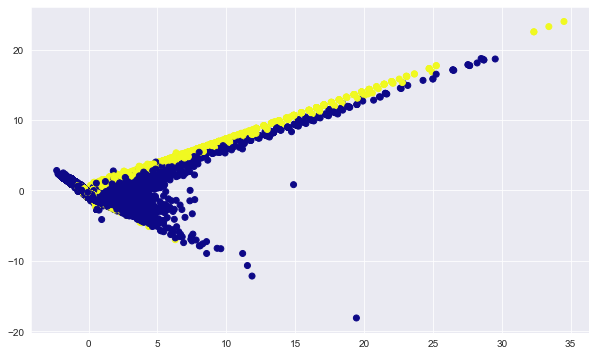

In [82]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.scatter(DFpca[:,0],DFpca[:,1],c=train['is_bot'],cmap='plasma')

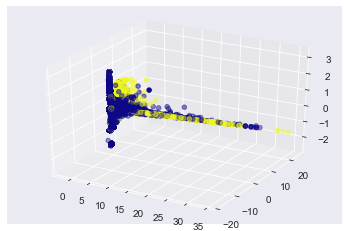

In [83]:
ax = plt.axes(projection='3d')
ax.scatter3D(DF3pca[:,0], DF3pca[:,1], DF3pca[:,2],c=train['is_bot'], cmap='plasma');

In [47]:
scaled_test.shape

(130834, 8)

Isolation Forest
---

In [44]:
from sklearn.ensemble import IsolationForest
Iforest= IsolationForest(n_estimators=30,contamination=0.08)

In [45]:
Iforest_train = Iforest.fit(scaled_train)
forest_label = Iforest.predict(scaled_test)

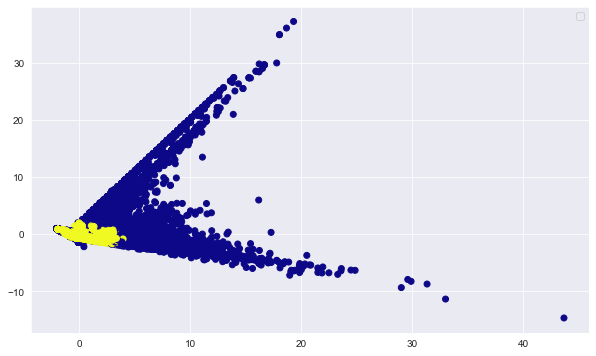

In [46]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.legend(forest_label)
plt.scatter(DFpca[:,0],DFpca[:,1],c=forest_label,cmap='plasma')

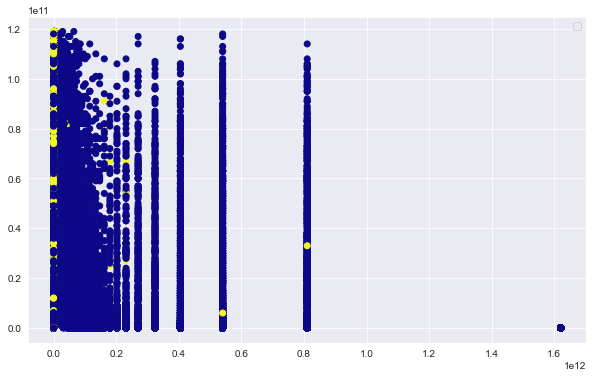

In [68]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.legend(forest_label)
plt.scatter(train['avg_time_interval'],train['lf_time_interval'],c=train['is_bot'],cmap='plasma')

In [47]:
train[forest_label==-1]

med_response_length  \
index client_ip       user_agent                                                                
0     126.145.72.90   FreshpingBot/1.0 (+https://freshping.io/)                       63379.0   
      14.6.66.228     Mozilla/5.0 (Linux; Android 8.1.0; BKK-LX2) App...              30290.5   
      186.236.39.213  Mozilla/5.0+(compatible; UptimeRobot/2.0; http:...                  0.0   
      207.213.193.143 Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bui...              82562.0   
                      Googlebot-Image/1.0                                                 0.0   
...                                                                                       ...   
300   35.26.123.225   Mozilla/5.0 (iPhone; CPU iPhone OS 14_4 like Ma...                  0.0   
      35.33.222.66    Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A715...                  0.0   
      37.192.112.41   Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537...               7724.5   
      67.149.194.62   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...              29827.0   
      92.130.186.37   Mozilla/5.0 (Linux; Android 8.0.0; SM-G570F) Ap...                  0.0   

                                                                          med_depth  \
index client_ip       user_agent                                                      
0     126.145.72.90   FreshpingBot/1.0 (+https://freshping.io/)                 1.0   
      14.6.66.228     Mozilla/5.0 (Linux; Android 8.1.0; BKK-LX2) App...        1.0   
      186.236.39.213  Mozilla/5.0+(compatible; UptimeRobot/2.0; http:...        1.0   
      207.213.193.143 Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bui...        3.0   
                      Googlebot-Image/1.0                                       3.0   
...                                                                             ...   
300   35.26.123.225   Mozilla/5.0 (iPhone; CPU iPhone OS 14_4 like Ma...        1.0   
      35.33.222.66    Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A715...        1.0   
      37.192.112.41   Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537...        2.0   
      67.149.194.62   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...        1.0   
      92.130.186.37   Mozilla/5.0 (Linux; Android 8.0.0; SM-G570F) Ap...        2.0   

                                                                          avg_response_time  \
index client_ip       user_agent                                                              
0     126.145.72.90   FreshpingBot/1.0 (+https://freshping.io/)                   32.000000   
      14.6.66.228     Mozilla/5.0 (Linux; Android 8.1.0; BKK-LX2) App...           4.000000   
      186.236.39.213  Mozilla/5.0+(compatible; UptimeRobot/2.0; http:...           4.000000   
      207.213.193.143 Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bui...        1080.400000   
                      Googlebot-Image/1.0                                         19.257143   
...                                                                                     ...   
300   35.26.123.225   Mozilla/5.0 (iPhone; CPU iPhone OS 14_4 like Ma...        2244.578947   
      35.33.222.66    Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A715...        2002.512821   
      37.192.112.41   Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537...         145.588235   
      67.149.194.62   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...          10.588235   
      92.130.186.37   Mozilla/5.0 (Linux; Android 8.0.0; SM-G570F) Ap...        1326.803922   

                                                                          avg_time_interval  \
index client_ip       user_agent                                                              
0     126.145.72.90   FreshpingBot/1.0 (+https://freshping.io/)                1.620780e+12   
      14.6.66.228     Mozilla/5.0 (Linux; Android 8.1.0; BKK-LX2) App...       8.103899e+11   
      186.236.39.213  Mozilla/5.0+(compatible; UptimeRobot/2.0; 

In [48]:
train[forest_label==-1]['is_bot'].value_counts()

0    8984
1    2590
Name: is_bot, dtype: int64

In [49]:
train.groupby(forest_label).mean()['is_bot']

-1    0.223777
 1    0.131939
Name: is_bot, dtype: float64

In [50]:
train.groupby(forest_label).mean()['avg_time_interval'],train.groupby(forest_label).mean()['std_time_interval']

(-1    1.395883e+11
  1    2.726500e+11
 Name: avg_time_interval, dtype: float64,
 -1    1.551468e+11
  1    2.620466e+11
 Name: std_time_interval, dtype: float64)

In [51]:
train.groupby(forest_label).median()['avg_time_interval'],train.groupby(forest_label).median()['std_time_interval']

(-1     28967.234262
  1    708000.000000
 Name: avg_time_interval, dtype: float64,
 -1     44037.862497
  1    625728.439185
 Name: std_time_interval, dtype: float64)

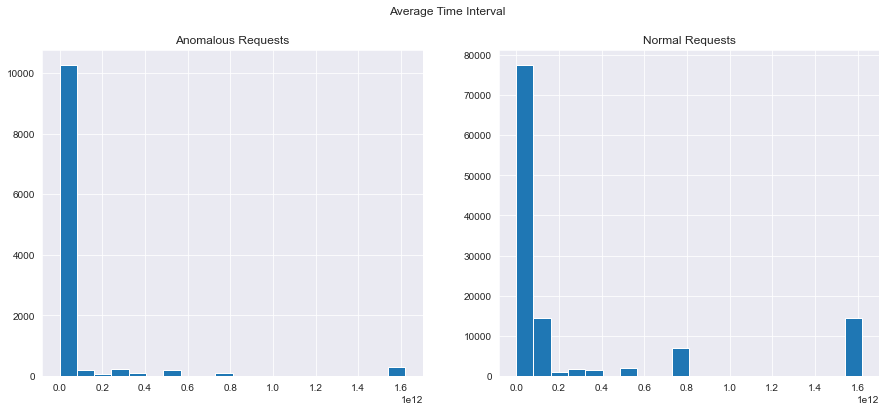

In [65]:
fig, axes= plt.subplots(1,2,figsize=(15,6))

axes[0].hist(train[forest_label==-1]['avg_time_interval'],bins = 20)
axes[0].set_title('Anomalous Requests')
axes[1] = train[forest_label==1]['avg_time_interval'].hist(bins=20)
plt.title('Normal Requests')
plt.suptitle('Average Time Interval')
plt.show()

Text(0.5, 0.98, 'Average Standard Deviation of Time Intervals between Requests')

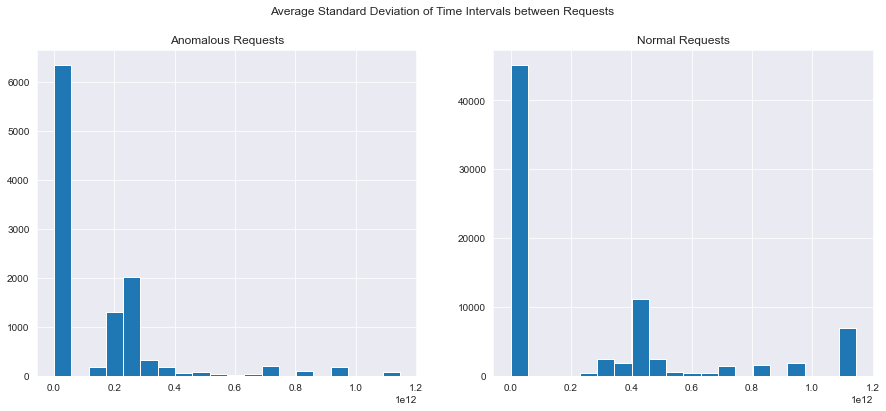

In [66]:
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(15,6) ,sharex=True)
axes1.hist(train[forest_label==-1]['std_time_interval'],bins = 20)
axes1.set_title('Anomalous Requests')
axes2 = train[forest_label==1]['std_time_interval'].hist(bins=20)
plt.title('Normal Requests')
plt.suptitle('Average Standard Deviation of Time Intervals between Requests')

In [67]:
train.groupby(forest_label).mean()['std_depth'],train.groupby(forest_label).mean()['number_of_requests']

(-1    0.761011
  1    0.417426
 Name: std_depth, dtype: float64,
 -1    49.331839
  1     5.800604
 Name: number_of_requests, dtype: float64)

In [68]:
train.groupby(forest_label).median()['std_depth'],train.groupby(forest_label).median()['number_of_requests']

(-1    0.897634
  1    0.363137
 Name: std_depth, dtype: float64,
 -1    42
  1     2
 Name: number_of_requests, dtype: int64)

In [69]:
train.groupby(forest_label).median()['times_ip_changed'],train.groupby(forest_label).mean()['times_ip_changed']

(-1    2
  1    6
 Name: times_ip_changed, dtype: int64,
 -1    13.803306
  1    29.169603
 Name: times_ip_changed, dtype: float64)

Text(0.5, 0.98, 'Average Standard Deviation of Depth between Requests')

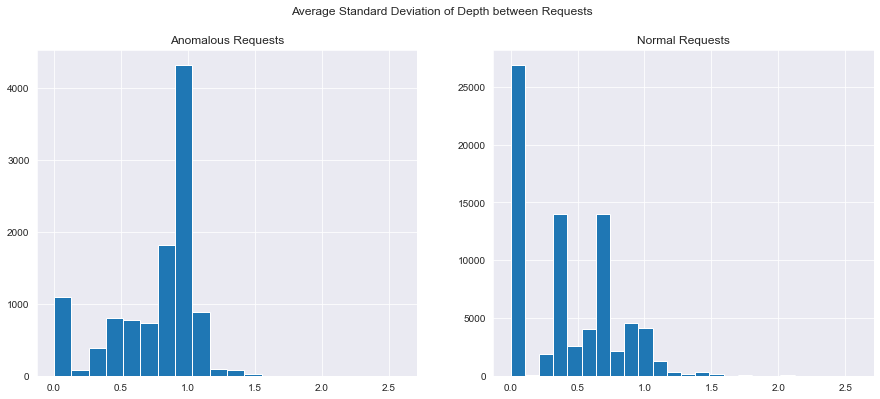

In [70]:
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(15,6) ,sharex=True)
axes1.hist(train[forest_label==-1]['std_depth'],bins = 20)
axes1.set_title('Anomalous Requests')
axes2 = train[forest_label==1]['std_depth'].hist(bins=20)
plt.title('Normal Requests')
plt.suptitle('Average Standard Deviation of Depth between Requests')

Text(0.5, 0.98, 'Average Number of Requests in 2 Minutes')

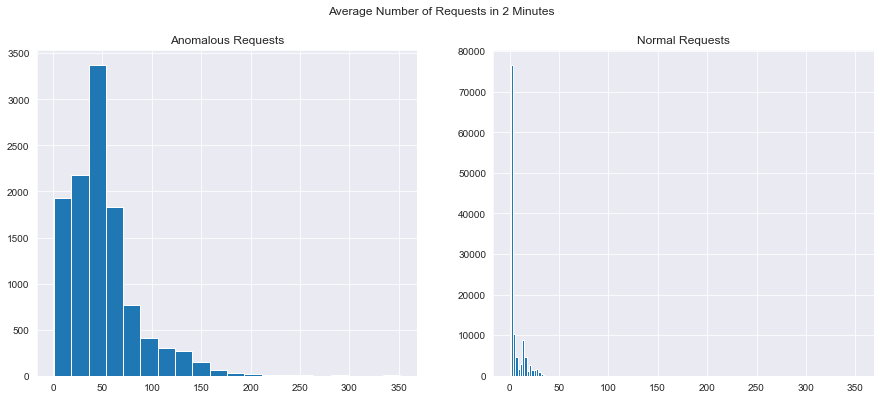

In [71]:
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(15,6) ,sharex=True)
axes1.hist(train[forest_label==-1]['number_of_requests'],bins = 20)
axes1.set_title('Anomalous Requests')
axes2 = train[forest_label==1]['number_of_requests'].hist(bins=20)
plt.title('Normal Requests')
plt.suptitle('Average Number of Requests in 2 Minutes')

In [72]:
train.groupby(forest_label).mean()['html/css'],train.groupby(forest_label).mean()['4xx/200']


(-1    3.510364
  1    0.091967
 Name: html/css, dtype: float64,
 -1    0.104324
  1    0.000432
 Name: 4xx/200, dtype: float64)

In [73]:
train.groupby(forest_label).median()['html/css'],train.groupby(forest_label).median()['4xx/200']

(-1    1.857143
  1    0.000000
 Name: html/css, dtype: float64,
 -1    0.0
  1    0.0
 Name: 4xx/200, dtype: float64)

Text(0.5, 0.98, 'Average Value of html/css between Requests')

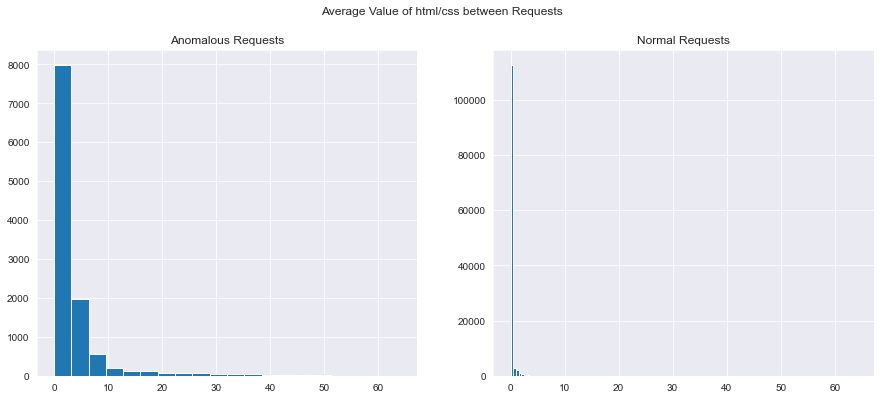

In [74]:
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(15,6) ,sharex=True)
axes1.hist(train[forest_label==-1]['html/css'],bins = 20)
axes1.set_title('Anomalous Requests')
axes2 = train[forest_label==1]['html/css'].hist(bins=20)
plt.title('Normal Requests')
plt.suptitle('Average Value of html/css between Requests')

Text(0.5, 0.98, 'Average Value of 4xx/200 Status Codes between Requests')

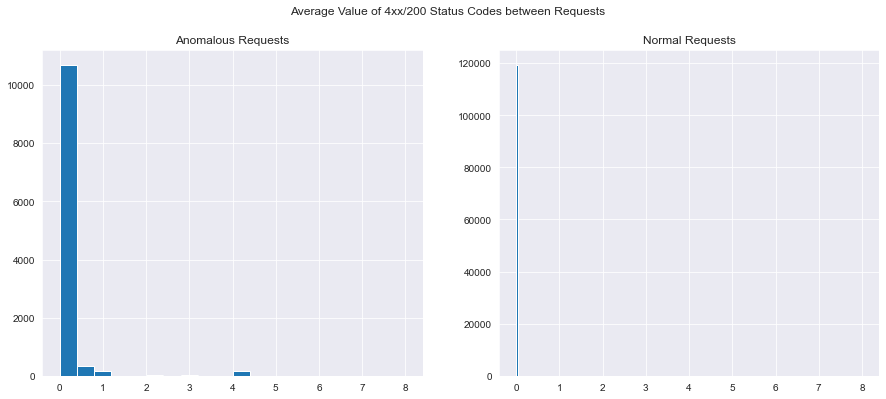

In [75]:
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(15,6) ,sharex=True)
axes1.hist(train[forest_label==-1]['4xx/200'],bins = 20)
axes1.set_title('Anomalous Requests')

axes2 = train[forest_label==1]['4xx/200'].hist(bins=20)
plt.title('Normal Requests')
plt.suptitle('Average Value of 4xx/200 Status Codes between Requests')

In [77]:
from  sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(n_neighbors = 2, metric = "manhattan", contamination = 0.02,novelty=True)
LOF.fit(scaled_test[forest_label==-1])
lof_label = LOF.predict(scaled_test[forest_label==-1])

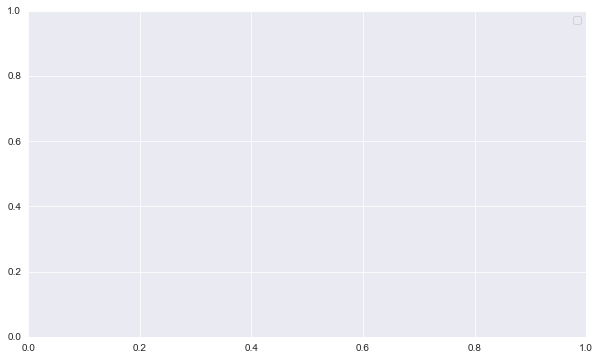

In [80]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.legend(forest_label)
plt.scatter(DFpca[:,0],DFpca[:,1],c=lof_label,cmap='plasma')

In [ ]:
train[(forest_label==-1)][(lof_label==1)]

In [203]:
train[lof_label==-1]['is_bot'].value_counts()

1    2426
0     859
Name: is_bot, dtype: int64

In [204]:
train.groupby(lof_label).mean()['is_bot']

-1    0.738508
 1    0.124650
Name: is_bot, dtype: float64

In [205]:
train.groupby(lof_label).mean()['avg_time_interval'],train.groupby(lof_label).mean()['std_time_interval']

(-1    3.184648e+10
  1    2.667776e+11
 Name: avg_time_interval, dtype: float64,
 -1    6.059248e+10
  1    2.536729e+11
 Name: std_time_interval, dtype: float64)

In [206]:
train.groupby(lof_label).median()['avg_time_interval'],train.groupby(lof_label).median()['std_time_interval']

(-1     95500.0
  1    720000.0
 Name: avg_time_interval, dtype: float64,
 -1     45420.993678
  1    632781.948082
 Name: std_time_interval, dtype: float64)

In [207]:
train.groupby(lof_label).mean()['std_depth'],train.groupby(lof_label).mean()['number_of_requests']

(-1    0.455345
  1    0.460955
 Name: std_depth, dtype: float64,
 -1    8.019178
  1    9.624960
 Name: number_of_requests, dtype: float64)

In [208]:
train.groupby(lof_label).median()['std_depth'],train.groupby(lof_label).median()['number_of_requests']

(-1    0.468807
  1    0.404520
 Name: std_depth, dtype: float64,
 -1    3
  1    2
 Name: number_of_requests, dtype: int64)

In [209]:
train.groupby(lof_label).mean()['html/css'],train.groupby(lof_label).mean()['4xx/200']


(-1    0.311847
  1    0.391108
 Name: html/css, dtype: float64,
 -1    0.005805
  1    0.009557
 Name: 4xx/200, dtype: float64)

In [211]:
train.groupby(lof_label).median()['html/css'],train.groupby(lof_label).median()['4xx/200']

(-1    0.0
  1    0.0
 Name: html/css, dtype: float64,
 -1    0.0
  1    0.0
 Name: 4xx/200, dtype: float64)

In [212]:
train.groupby(lof_label).median()['times_ip_changed'],train.groupby(lof_label).mean()['times_ip_changed']

(-1    8
  1    6
 Name: times_ip_changed, dtype: int64,
 -1    10.924505
  1    28.269355
 Name: times_ip_changed, dtype: float64)

In [53]:
labeled = train.reset_index(level=2)
labeled['label'] = labeled['user_agent'].apply(lambda x:-1 if (str(x).lower().find('google')>=0 or
                                                               str(x).lower().find('python')>=0)==True else 1)

In [54]:
labeled['label'].value_counts()

 1    121199
-1      9635
Name: label, dtype: int64

In [ ]:
labeled= labeled.drop('model_label',axis=1)

In [480]:
labeled = pd.concat( [labeled.reset_index(),pd.DataFrame(forest_label)],axis=1)

In [481]:
labeled = labeled.reset_index()
labeled = labeled.drop('level_0',axis=1)
labeled = labeled.set_index(['index','client_ip','user_agent'])

In [482]:
labeled.columns = ['med_response_length','med_depth','avg_response_time','avg_time_interval','std_response_time',
                   'std_time_interval','is_pc','Get','Post','image','400','html/css','4xx/200','location','lf_time_interval',
                   'max_depth','std_depth','number_of_requests','is_bot','label','model_label']

In [483]:
labeled['model_label'].value_counts()

 1    121675
-1      9159
Name: model_label, dtype: int64

In [484]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
print(classification_report(labeled['label'],labeled['model_label']))
print(confusion_matrix(labeled['label'],labeled['model_label']))


              precision    recall  f1-score   support

          -1       0.04      0.04      0.04      9635
           1       0.92      0.93      0.93    121199

    accuracy                           0.86    130834
   macro avg       0.48      0.48      0.48    130834
weighted avg       0.86      0.86      0.86    130834

[[   347   9288]
 [  8812 112387]]
